In [1]:
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
from glob import glob
import tqdm
from sklearn.preprocessing import LabelEncoder

# Notları kategorilere dönüştürme fonksiyonu
def map_grades_to_categories(grades):
    bins = [0, 60, 70, 80, 90, 101]
    labels = ['F', 'D', 'C', 'B', 'A']
    return pd.cut(grades, bins=bins, labels=labels, right=False)

# HTML dosyalarından veri çekme fonksiyonu
def extract_data_from_html(html_folder):
    data = []
    data_path = os.path.join(html_folder, "*.html")
    for path in tqdm.tqdm(sorted(glob(data_path))):
        file_code = os.path.basename(path).split(".")[0]
        with open(path, "r", encoding="latin1") as fh:
            html_page = fh.read()
            soup = BeautifulSoup(html_page, "html.parser")
            data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
            conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

            for i, convo in enumerate(conversations):
                convo_texts = convo.find_all("div", attrs={"data-message-author-role": re.compile(r"[user|assistant]")})
                if len(convo_texts) > 0:
                    role = convo_texts[0].get("data-message-author-role")
                    if role == "user":
                        data.append({
                            "code": file_code,
                            "text": convo_texts[0].text
                        })
    return pd.DataFrame(data)

# Veri çekme
html_folder = "content"
questions_df = extract_data_from_html(html_folder)

# İlk 5 satırı yazdır
questions_df.head()

100%|██████████| 127/127 [00:23<00:00,  5.36it/s]


,code,text
0,0031c86e-81f4-4eef-9e0e-28037abf9883,Load a CSV file into a Pandas in Python. The f...
1,0031c86e-81f4-4eef-9e0e-28037abf9883,Provide Python code to understand a dataset us...
2,0031c86e-81f4-4eef-9e0e-28037abf9883,You will preprocess the data now\n1. Check for...
3,0031c86e-81f4-4eef-9e0e-28037abf9883,You already provide code for this but please r...
4,0031c86e-81f4-4eef-9e0e-28037abf9883,Calculate and Visualize the correlations of al...


In [2]:
from nltk.corpus import stopwords
from collections import Counter
import string
import nltk
nltk.download('stopwords')

# Define a custom list of additional stopwords and symbols to remove
additional_stopwords = {"=", "#", "pts)", "line", "file", "use", "import", "data", "code"}
custom_stopwords = set(stopwords.words('english')) | additional_stopwords

# Define a function to filter and count top words
def get_top_words(texts, n=10):
    words = ' '.join(texts).split()
    # Filter out stopwords and punctuation
    filtered_words = [word for word in words if word.lower() not in custom_stopwords and word not in string.punctuation]
    word_counts = Counter(filtered_words)
    return word_counts.most_common(n)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def clean_text(text):
    # Remove punctuation and digits
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in custom_stopwords])
    return text

# Apply the cleaning function to the text column
questions_df['text'] = questions_df['text'].apply(clean_text)


In [5]:
# Not verilerini yükleme
scores_df = pd.read_csv("scores.csv", sep=",")
scores_df['grade_category'] = map_grades_to_categories(scores_df['grade'])

print(scores_df.head())



   Unnamed: 0                                  code  grade grade_category
0           0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0              A
1           1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0              A
2           2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0              A
3           3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0              A
4           4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0              A


In [6]:
HW_questions = [
"""Load training dataset (5 pts)
*  Read the .csv file with the pandas library""",
                       ###########
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)
> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.
> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function) """,
                       ###########
"""Set X & y, split data (5 pts)
*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.""",
                       ###########
"""Features and Correlations (10 pts)
* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.
* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.
* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.
* __Note:__ You get can get help from GPT.""",
                       ###########
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the [Scikit learn decision tree documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)""",
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.""",
                       ###########
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics""",
                       ###########
"""Find the information gain on the first split (10 pts)"""]
points_list = []

for text in HW_questions:
    match = re.search(r'(\d+) pts', str(text))
    if match:
        points_list.append(int(match.group(1)))

HW_questions_Df = pd.DataFrame(list(zip(HW_questions, points_list)), columns=['Questions', 'Points'])

In [10]:
!pip install sentence_transformers
#if working on colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 946.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=e88a6d6add53f41937ca0b2dd5733d91faa613e7e54c36bf949f665ef25385cf
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

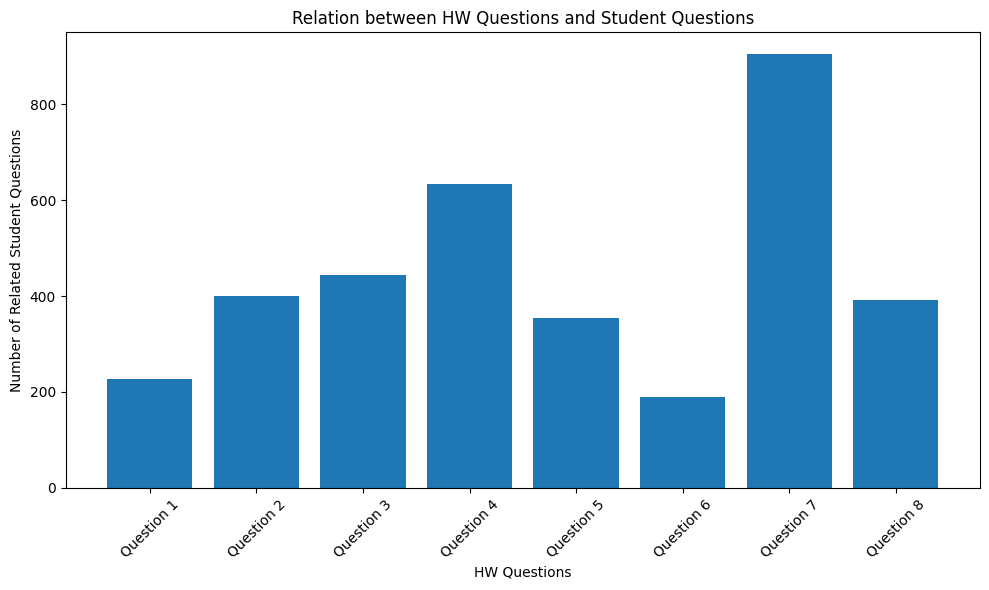

In [11]:

import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

hw_vectors = model.encode(HW_questions_Df['Questions'].tolist())
question_vectors = model.encode(questions_df['text'].tolist())

nn = NearestNeighbors(n_neighbors=1, metric='cosine').fit(hw_vectors)
distances, indices = nn.kneighbors(question_vectors)

closest_hw_questions = indices.flatten()
related_questions_count = pd.Series(closest_hw_questions).value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(related_questions_count.index, related_questions_count.values)
plt.xlabel('HW Questions')
plt.ylabel('Number of Related Student Questions')
plt.title('Relation between HW Questions and Student Questions')

# X-ekseni etiketlerini düzenleme
xtick_labels = [f'Question {i+1}' for i in range(len(related_questions_count))]
plt.xticks(range(len(related_questions_count)), labels=xtick_labels, rotation=45)
plt.tight_layout()  # Grafik düzenini iyileştirmek için
plt.show()

In [12]:
# Veri setlerini birleştirme
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

combined_df = pd.merge(questions_df, scores_df, on='code', how='inner')

In [13]:
# Aggregate texts by code
aggregated_texts = combined_df.groupby('code')['text'].apply(' '.join).reset_index()

# Merge the aggregated texts back with the scores_df
combined_df = pd.merge(aggregated_texts, scores_df, on='code')

In [14]:
combined_df


,code,text,Unnamed: 0,grade,grade_category
0,0031c86e-81f4-4eef-9e0e-28037abf9883,load csv pandas python named cshwdatasetcsv co...,134,48.0,F
1,0225686d-b825-4cac-8691-3a3a5343df2b,dataset contains following columns create mode...,85,99.0,A
2,041f950b-c013-409a-a642-cffff60b9d4b,csv columns species species penguin adelie chi...,104,90.0,A
3,04f91058-d0f8-4324-83b2-19c671f433dc,display variable names pandas dataframe check ...,1,97.0,A
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,machine leraning homework using google collab ...,81,100.0,A
...,...,...,...,...,...
135,f2f18684-4a16-4c05-a2d1-c0f96d1de869,handle missing values dataset python like prof...,59,100.0,A
136,f852596d-fdca-45aa-9050-d4f76ce6a53c,python read named cshwdatasetcsv contains foll...,94,98.0,A
137,f8ec3336-fd48-4654-ad98-62ccfb96d096,necessary libraries machine learning analys lo...,84,100.0,A
138,fb8de815-224c-4d06-9fd4-7156d1a9920d,hi homework like cs machine learning fall home...,37,98.0,A


In [15]:
# Step 1: Merge DataFrames
combined_df = pd.merge(questions_df, scores_df, on='code', how='inner')

# Step 2: Aggregate Texts by Code
aggregated_texts = combined_df.groupby('code')['text'].apply(' '.join).reset_index()

# Merge the aggregated texts back with the scores_df
combined_df = pd.merge(aggregated_texts, scores_df, on='code')

combined_df



,code,text,Unnamed: 0,grade,grade_category
0,0031c86e-81f4-4eef-9e0e-28037abf9883,load csv pandas python named cshwdatasetcsv co...,134,48.0,F
1,0225686d-b825-4cac-8691-3a3a5343df2b,dataset contains following columns create mode...,85,99.0,A
2,041f950b-c013-409a-a642-cffff60b9d4b,csv columns species species penguin adelie chi...,104,90.0,A
3,04f91058-d0f8-4324-83b2-19c671f433dc,display variable names pandas dataframe check ...,1,97.0,A
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,machine leraning homework using google collab ...,81,100.0,A
...,...,...,...,...,...
135,f2f18684-4a16-4c05-a2d1-c0f96d1de869,handle missing values dataset python like prof...,59,100.0,A
136,f852596d-fdca-45aa-9050-d4f76ce6a53c,python read named cshwdatasetcsv contains foll...,94,98.0,A
137,f8ec3336-fd48-4654-ad98-62ccfb96d096,necessary libraries machine learning analys lo...,84,100.0,A
138,fb8de815-224c-4d06-9fd4-7156d1a9920d,hi homework like cs machine learning fall home...,37,98.0,A


In [16]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_tfidf = tfidf_vectorizer.fit_transform(combined_df['text'])

# If you have a target variable (e.g., grade_category) in your scores_df:
y = combined_df['grade']  # Replace 'grade_category' with the actual target column name

# Step 4: Split Data for Training/Testing (if necessary)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.65, random_state=42)

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Assuming HW_questions is a list of your homework questions
# and questions_df['text'] contains student questions

# Combine HW and student questions to fit the vectorizer
combined_questions = HW_questions + questions_df['text'].tolist()
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_questions)

# Split the matrix back into HW questions and student questions
hw_vectors = tfidf_matrix[:len(HW_questions), :]
student_vectors = tfidf_matrix[len(HW_questions):, :]

# Step 2: Calculate Cosine Similarity
cos_similarities = cosine_similarity(student_vectors, hw_vectors)

# Step 3: Analyze or Use the Similarities
# Example: Find the most similar homework question for each student question
most_similar_hw_for_each_student = cos_similarities.argmax(axis=1)
similarities_scores = cos_similarities.max(axis=1)

# Creating a DataFrame for better visualization
similarity_df = pd.DataFrame({
    'Student Question': questions_df['text'],
    'Most Similar HW Question': [HW_questions[i] for i in most_similar_hw_for_each_student],
    'Similarity Score': similarities_scores
})

# Display the result
print(similarity_df.head())

                                    Student Question  \
0  load csv pandas python named cshwdatasetcsv co...   
1  provide python understand dataset using pandas...   
2  preprocess check missing values handle either ...   
3  already provide please recreate part shuffling...   
4  calculate visualize correlations features pand...   

                            Most Similar HW Question  Similarity Score  
0  Load training dataset (5 pts)\n*  Read the .cs...          0.221013  
1  Understanding the dataset & Preprocessing (15 ...          0.525308  
2  Understanding the dataset & Preprocessing (15 ...          0.287706  
3  Set X & y, split data (5 pts)\n*   Shuffle the...          0.350748  
4  Features and Correlations (10 pts)\n* Correlat...          0.402131  


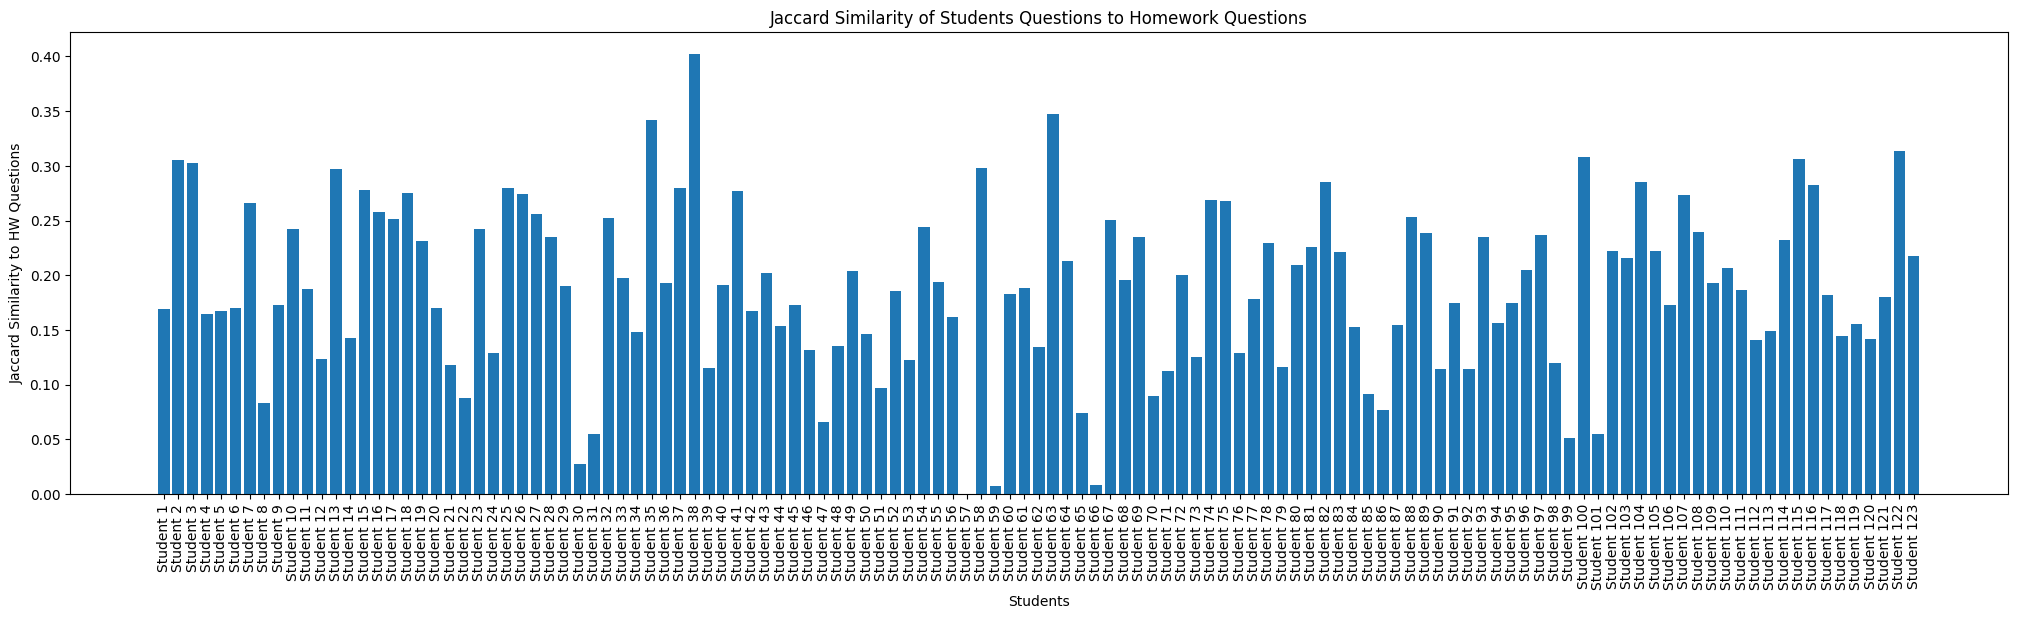

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming HW_questions and questions_df are already defined

def create_set_of_words(text_list):
    return set(word for text in text_list for word in text.lower().split())

hw_questions_set = create_set_of_words(HW_questions)
student_questions_sets = questions_df.groupby('code')['text'].apply(create_set_of_words)

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# Calculate Jaccard similarity for each student's set of questions
student_questions_sets = questions_df.groupby('code')['text'].apply(create_set_of_words)
jaccard_scores = student_questions_sets.apply(lambda x: jaccard_similarity(x, hw_questions_set))

# Prepare DataFrame for visualization
jaccard_df = pd.DataFrame({'Student': [f'Student {i+1}' for i in range(len(jaccard_scores))],
                           'Jaccard Similarity': jaccard_scores.values})

# Visualization
plt.figure(figsize=(25, 6))
plt.bar(jaccard_df['Student'], jaccard_df['Jaccard Similarity'])
plt.xlabel('Students')
plt.ylabel('Jaccard Similarity to HW Questions')
plt.title('Jaccard Similarity of Students Questions to Homework Questions')
plt.xticks(rotation=90)
plt.show()


In [19]:
combined_df

,code,text,Unnamed: 0,grade,grade_category
0,0031c86e-81f4-4eef-9e0e-28037abf9883,load csv pandas python named cshwdatasetcsv co...,134,48.0,F
1,0225686d-b825-4cac-8691-3a3a5343df2b,dataset contains following columns create mode...,85,99.0,A
2,041f950b-c013-409a-a642-cffff60b9d4b,csv columns species species penguin adelie chi...,104,90.0,A
3,04f91058-d0f8-4324-83b2-19c671f433dc,display variable names pandas dataframe check ...,1,97.0,A
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,machine leraning homework using google collab ...,81,100.0,A
...,...,...,...,...,...
135,f2f18684-4a16-4c05-a2d1-c0f96d1de869,handle missing values dataset python like prof...,59,100.0,A
136,f852596d-fdca-45aa-9050-d4f76ce6a53c,python read named cshwdatasetcsv contains foll...,94,98.0,A
137,f8ec3336-fd48-4654-ad98-62ccfb96d096,necessary libraries machine learning analys lo...,84,100.0,A
138,fb8de815-224c-4d06-9fd4-7156d1a9920d,hi homework like cs machine learning fall home...,37,98.0,A


In [20]:
# Create a DataFrame to hold individual cosine similarities
individual_cosine_sim_df = pd.DataFrame({
    'code': questions_df['code'],
    'Student Question': questions_df['text'],
    'Cosine Similarity': cos_similarities.max(axis=1)
})

# Aggregate cosine similarities by student (code)
overall_cosine_sim_df = individual_cosine_sim_df.groupby('code')['Cosine Similarity'].mean().reset_index()

overall_cosine_sim_df

,code,Cosine Similarity
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.320343
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.518495
2,041f950b-c013-409a-a642-cffff60b9d4b,0.153453
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.188698
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.218418
...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.274848
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.190404
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.351828
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.510079


In [21]:
# Calculate Jaccard similarity for each student's aggregated questions
def calculate_jaccard_for_student(group):
    student_questions_set = create_set_of_words(group['text'])
    return jaccard_similarity(student_questions_set, hw_questions_set)

# Apply the function to each group of student questions
overall_jaccard_scores = questions_df.groupby('code').apply(calculate_jaccard_for_student)

# Convert to DataFrame
overall_jaccard_df = pd.DataFrame({
    'code': overall_jaccard_scores.index,
    'Overall Jaccard Similarity': overall_jaccard_scores.values
})

overall_jaccard_df

,code,Overall Jaccard Similarity
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.169154
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.305389
2,041f950b-c013-409a-a642-cffff60b9d4b,0.302703
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.164557
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.167178
...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.155313
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.141337
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.180511
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.313218


In [22]:
combined_df = combined_df.merge(overall_jaccard_df, on='code', how='left')


In [23]:
combined_df = combined_df.merge(overall_cosine_sim_df, on='code', how='left')

In [24]:
combined_df

,code,text,Unnamed: 0,grade,grade_category,Overall Jaccard Similarity,Cosine Similarity
0,0031c86e-81f4-4eef-9e0e-28037abf9883,load csv pandas python named cshwdatasetcsv co...,134,48.0,F,0.169154,0.320343
1,0225686d-b825-4cac-8691-3a3a5343df2b,dataset contains following columns create mode...,85,99.0,A,0.305389,0.518495
2,041f950b-c013-409a-a642-cffff60b9d4b,csv columns species species penguin adelie chi...,104,90.0,A,0.302703,0.153453
3,04f91058-d0f8-4324-83b2-19c671f433dc,display variable names pandas dataframe check ...,1,97.0,A,0.164557,0.188698
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,machine leraning homework using google collab ...,81,100.0,A,0.167178,0.218418
...,...,...,...,...,...,...,...
135,f2f18684-4a16-4c05-a2d1-c0f96d1de869,handle missing values dataset python like prof...,59,100.0,A,0.141337,0.190404
136,f852596d-fdca-45aa-9050-d4f76ce6a53c,python read named cshwdatasetcsv contains foll...,94,98.0,A,0.180511,0.351828
137,f8ec3336-fd48-4654-ad98-62ccfb96d096,necessary libraries machine learning analys lo...,84,100.0,A,0.313218,0.510079
138,fb8de815-224c-4d06-9fd4-7156d1a9920d,hi homework like cs machine learning fall home...,37,98.0,A,0.217973,0.305651


In [25]:
# Remove redundant columns
columns_to_drop = ['Cosine Similarity_x', 'Jaccard Similarity_x', 'Cosine Similarity_y', 'Jaccard Similarity_y']
combined_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Rename columns if necessary
combined_df.rename(columns={'Overall Jaccard Similarity': 'Jaccard Similarity', 'Cosine Similarity': 'Cosine Similarity'}, inplace=True)

# Display the cleaned DataFrame
print(combined_df.head())

                                   code  \
0  0031c86e-81f4-4eef-9e0e-28037abf9883   
1  0225686d-b825-4cac-8691-3a3a5343df2b   
2  041f950b-c013-409a-a642-cffff60b9d4b   
3  04f91058-d0f8-4324-83b2-19c671f433dc   
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34   

                                                text  Unnamed: 0  grade  \
0  load csv pandas python named cshwdatasetcsv co...         134   48.0   
1  dataset contains following columns create mode...          85   99.0   
2  csv columns species species penguin adelie chi...         104   90.0   
3  display variable names pandas dataframe check ...           1   97.0   
4  machine leraning homework using google collab ...          81  100.0   

  grade_category  Jaccard Similarity  Cosine Similarity  
0              F            0.169154           0.320343  
1              A            0.305389           0.518495  
2              A            0.302703           0.153453  
3              A            0.164557           0.188698  


In [26]:
# Impute missing values in 'grade' with mean, median, or a fixed value
combined_df['grade'].fillna(combined_df['grade'].mean(), inplace=True)  # Example using mean

# Then, proceed with preparing your data for the model
X = combined_df[['Cosine Similarity', 'Jaccard Similarity']]
y = combined_df['grade'].astype(float)

# Split the data into training and testing sets, and so on...

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Ensure there are no NaN values in the target variable
combined_df['grade'] = combined_df['grade'].fillna(combined_df['grade'].mean())

# Features and Target Variable
X = combined_df[['Cosine Similarity', 'Jaccard Similarity']]
y = combined_df['grade'].astype(float)

# Splitting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.65, random_state=42)

In [28]:
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

# Predicting on Test Set
y_pred = rf_regressor.predict(X_test)

# Basic Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Initial Model - Mean Squared Error: {mse}")
print(f"Initial Model - R^2 Score: {r2}")


Initial Model - Mean Squared Error: 164.87889771739563
Initial Model - R^2 Score: -0.27585288958828813


In [29]:
from sklearn.model_selection import RandomizedSearchCV

# Updated Parameter Grid with valid 'max_features' options
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.75, None],
    'bootstrap': [True, False]
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=300,  # Increase the number of iterations
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model to the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_random = random_search.best_params_
print("Best Parameters (Randomized Search):", best_params_random)

best_rf_random = random_search.best_estimator_

# Predict and Evaluate with Best Model
y_pred_best_random = best_rf_random.predict(X_test)
mse_best_random = mean_squared_error(y_test, y_pred_best_random)
r2_best_random = r2_score(y_test, y_pred_best_random)
print(f"Optimized Model (Randomized Search) - Mean Squared Error: {mse_best_random}")
print(f"Optimized Model (Randomized Search) - R^2 Score: {r2_best_random}")






Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters (Randomized Search): {'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 0.75, 'max_depth': None, 'bootstrap': True}
Optimized Model (Randomized Search) - Mean Squared Error: 129.16270442017233
Optimized Model (Randomized Search) - R^2 Score: 0.0005233420229961983


In [30]:
import pandas as pd

# Predict using the optimized model from Randomized Search
y_pred_best_random = best_rf_random.predict(X_test)

# Create a DataFrame to compare actual and predicted grades
comparison_df = pd.DataFrame({
    'Actual Grade': y_test,
    'Predicted Grade': y_pred_best_random,
    'Absolute Error': abs(y_test - y_pred_best_random)
})

# Display the DataFrame
print(comparison_df.head())

# Optionally, you can calculate the average error
average_error = comparison_df['Absolute Error'].mean()
print(f"Average Absolute Error: {average_error}")



     Actual Grade  Predicted Grade  Absolute Error
108          96.0        93.255293        2.744707
67           90.0        89.789176        0.210824
31           93.0        95.471792        2.471792
119          96.0        94.156057        1.843943
42           98.0        94.477614        3.522386
Average Absolute Error: 7.164384686878039


In [31]:
# First, ensure that 'code' is part of your test DataFrame
# If you split your data into train and test before, ensure to retain 'code' in the test set
X_test_with_code = X_test.copy()
X_test_with_code['code'] = y_test.index  # Assuming 'code' is the index of y_test

# Predict using the optimized model from Randomized Search
y_pred_best_random = best_rf_random.predict(X_test)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Code': X_test_with_code['code'],
    'Actual Grade': y_test,
    'Predicted Grade': y_pred_best_random
})

# Calculate Absolute Error
comparison_df['Absolute Error'] = abs(comparison_df['Actual Grade'] - comparison_df['Predicted Grade'])

# Display the DataFrame
print(comparison_df.head())

# Calculate the average error
average_error = comparison_df['Absolute Error'].mean()
print(f"Average Absolute Error: {average_error}")



     Code  Actual Grade  Predicted Grade  Absolute Error
108   108          96.0        93.255293        2.744707
67     67          90.0        89.789176        0.210824
31     31          93.0        95.471792        2.471792
119   119          96.0        94.156057        1.843943
42     42          98.0        94.477614        3.522386
Average Absolute Error: 7.164384686878039


In [32]:
# Öğrenci notlarını ve beklenen notları bir veri çerçevesine ekleyerek hataları hesaplayalım
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Error': y_test - y_pred})

# Her öğrenci notu ile beklenen notu ve arasındaki hatayı yazdıralım
for index, row in result_df.iterrows():
    print(f'Actual Grade: {row["Actual"]}, Predicted Grade: {row["Predicted"]}, Error: {row["Error"]}')


Actual Grade: 96.0, Predicted Grade: 97.44, Error: -1.4399999999999977
Actual Grade: 90.0, Predicted Grade: 89.85, Error: 0.15000000000000568
Actual Grade: 93.0, Predicted Grade: 98.42, Error: -5.420000000000002
Actual Grade: 96.0, Predicted Grade: 97.04, Error: -1.0400000000000063
Actual Grade: 98.0, Predicted Grade: 93.69, Error: 4.310000000000002
Actual Grade: 100.0, Predicted Grade: 92.95, Error: 7.049999999999997
Actual Grade: 99.0, Predicted Grade: 86.7, Error: 12.299999999999997
Actual Grade: 78.0, Predicted Grade: 89.85, Error: -11.849999999999994
Actual Grade: 88.0, Predicted Grade: 84.87, Error: 3.1299999999999955
Actual Grade: 93.0, Predicted Grade: 99.13, Error: -6.1299999999999955
Actual Grade: 100.0, Predicted Grade: 80.14, Error: 19.86
Actual Grade: 100.0, Predicted Grade: 89.09, Error: 10.909999999999997
Actual Grade: 99.0, Predicted Grade: 93.14, Error: 5.859999999999999
Actual Grade: 100.0, Predicted Grade: 90.09, Error: 9.909999999999997
Actual Grade: 90.0, Predicted

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict using the optimized model
y_pred = best_rf_random.predict(X_test)

# Modelin tahminlerini kullanarak hata metriklerini hesapla
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error (MSE): 129.16270442017233
R^2 Score: 0.0005233420229961983


<ipython-input-34-8051b4c7aefd>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(comparison_df['Actual Grade'], hist=False, label='Actual Grades')
<ipython-input-34-8051b4c7aefd>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(comparison_df['Predicted Grade'], hist=False, labe

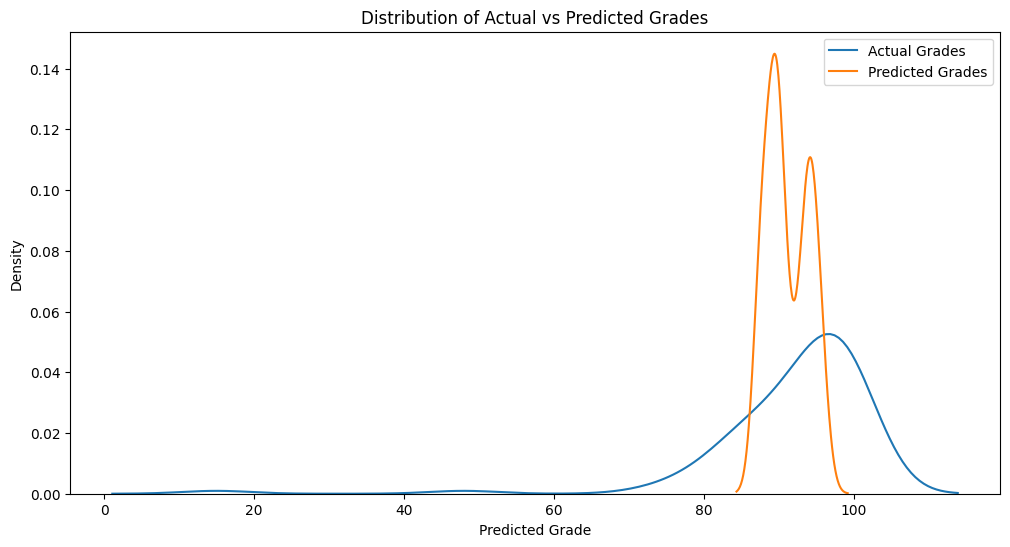

<ipython-input-34-8051b4c7aefd>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(comparison_df['Absolute Error'], bins=20, kde=False)


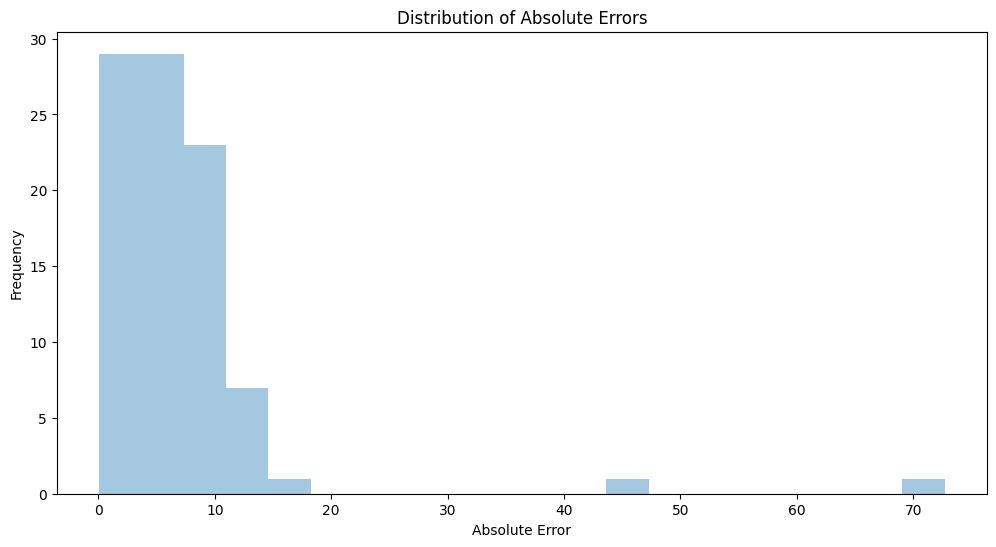

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gerçek ve Tahmin Edilen Notların Dağılımını Görselleştirme
plt.figure(figsize=(12, 6))
sns.distplot(comparison_df['Actual Grade'], hist=False, label='Actual Grades')
sns.distplot(comparison_df['Predicted Grade'], hist=False, label='Predicted Grades')
plt.title('Distribution of Actual vs Predicted Grades')
plt.legend()
plt.show()

# Hata Dağılımını Görselleştirme
plt.figure(figsize=(12, 6))
sns.distplot(comparison_df['Absolute Error'], bins=20, kde=False)
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.show()


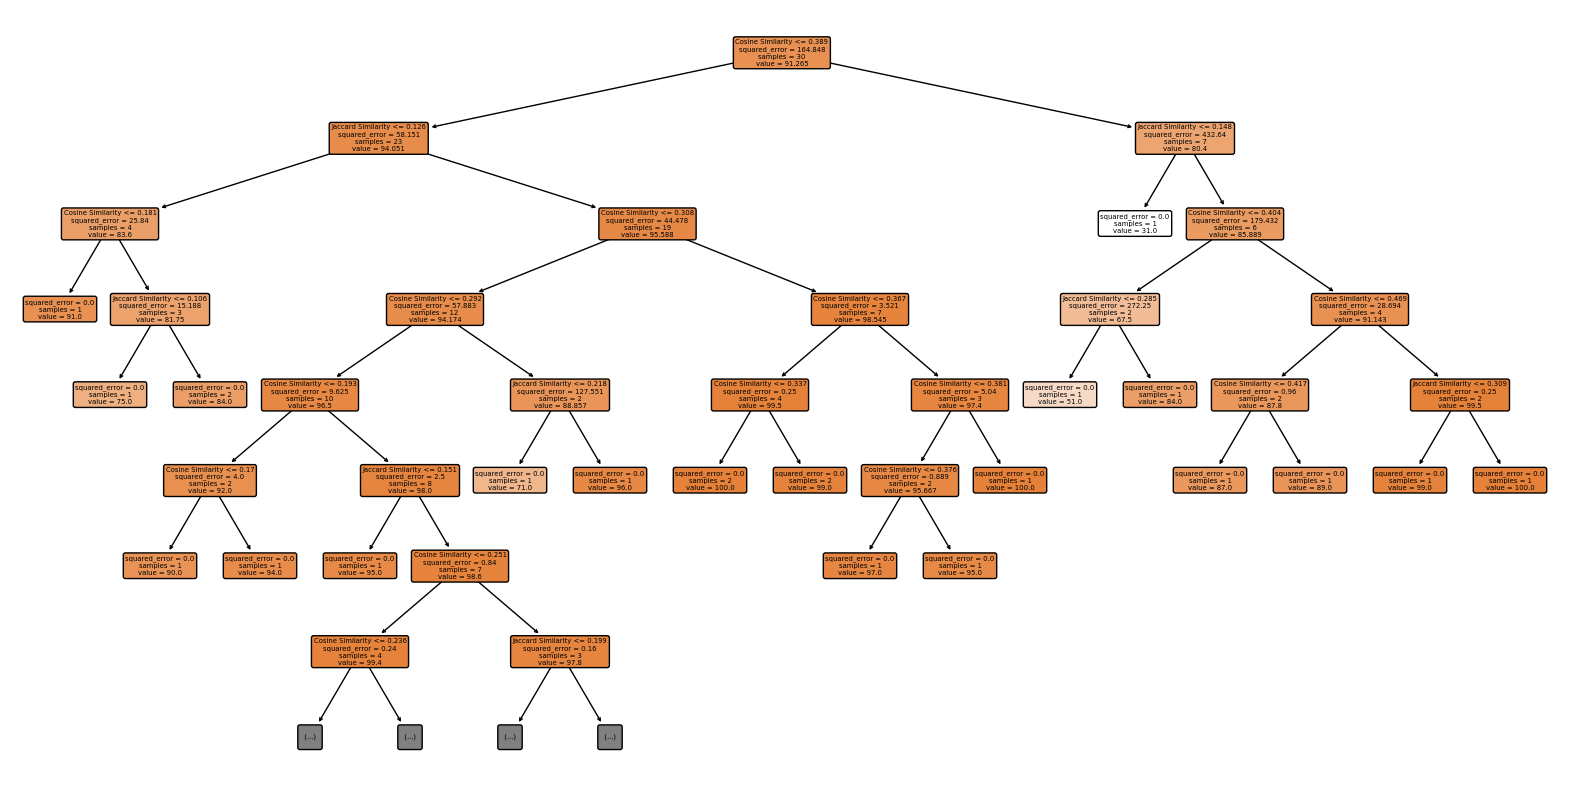

In [35]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Random Forest Regressor'dan ilk karar ağacını seç
first_tree = rf_regressor.estimators_[0]

# Karar Ağacını Görselleştir
plt.figure(figsize=(20, 10))  # Boyutları ayarlayabilirsiniz
plot_tree(first_tree,
          feature_names=['Cosine Similarity', 'Jaccard Similarity'],  # Özellik isimlerini ekleyin
          filled=True,
          rounded=True,
          max_depth=7)  # Maksimum derinlik

# Görseli PDF olarak kaydet
plt.savefig('hw.pdf', format='pdf')

# Görseli göster (opsiyonel)
plt.show()


In [ ]:
#pip install graphviz
#if working on colab.


In [36]:
from sklearn.tree import export_graphviz
import graphviz

# RandomForestRegressor'dan bir karar ağacını seç (örneğin, ilk ağaç)
first_tree = rf_regressor.estimators_[0]

# Karar ağacını DOT formatında dışa aktar
dot_data = export_graphviz(first_tree, out_file=None,
                           feature_names=['Cosine Similarity', 'Jaccard Similarity'],  # Özellik isimlerini ekleyin
                           filled=True, rounded=True,
                           special_characters=True)

# DOT verisini kullanarak Graphviz nesnesi oluştur
graph = graphviz.Source(dot_data)

# Grafiği bir dosya olarak kaydet (örneğin: 'decision_tree_hw.pdf')
graph.render("differentTree.pdf")


'differentTree.pdf.pdf'

In [37]:
top_words_by_grade = combined_df.groupby('grade_category')['text'].apply(lambda texts: get_top_words(texts))
print(top_words_by_grade)

grade_category
F    [(â, 35), (correlations, 34), (features, 31)...
D                                                   []
C    [(values, 35), (features, 34), (x, 27), (pts, ...
B    [(hyperparameters, 383), (values, 362), (datas...
A    [(dataset, 1158), (features, 1158), (values, 1...
Name: text, dtype: object


In [38]:
# Convert the output to a DataFrame for better visualization
top_words_df = pd.DataFrame(columns=['Grade', 'Top Words'])

for grade, words in top_words_by_grade.items():
    top_words_str = ', '.join([f"{word} ({count})" for word, count in words])
    top_words_df = top_words_df.append({'Grade': grade, 'Top Words': top_words_str}, ignore_index=True)

top_words_df.head()


<ipython-input-38-d226421e3109>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_words_df = top_words_df.append({'Grade': grade, 'Top Words': top_words_str}, ignore_index=True)
<ipython-input-38-d226421e3109>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_words_df = top_words_df.append({'Grade': grade, 'Top Words': top_words_str}, ignore_index=True)
<ipython-input-38-d226421e3109>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_words_df = top_words_df.append({'Grade': grade, 'Top Words': top_words_str}, ignore_index=True)
<ipython-input-38-d226421e3109>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_words_df = top_w

,Grade,Top Words
0,F,"â (35), correlations (34), features (31), va..."
1,D,
2,C,"values (35), features (34), x (27), pts (26), ..."
3,B,"hyperparameters (383), values (362), dataset (..."
4,A,"dataset (1158), features (1158), values (1154)..."


In [39]:
from prettytable import PrettyTable

# Create a PrettyTable object
table = PrettyTable()
table.field_names = ["Grade", "Top Words"]

# Fill the table with data
for index, row in top_words_df.iterrows():
    table.add_row([row['Grade'], row['Top Words']])

# Print the table
print(table)


+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Grade |                                                                            Top Words                                                                             |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   F   |                                                                                 â (35), correlations (34), features (31), variable (25), dataset (23), target (23), pts (19), healthmetrics (15), function (13), column (13)                                                                                  |
|   D   |                                                                                                                                                            